## Player Evaluation Summary notebook

This file reproduces most of the figures in PAPER.PDF. Most of the functions used here are defined in util.py.   
See README for more info, this is not the final version.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.construct import rand
import xgboost as xgb
import shap
from util import *
import plotly.express as px
from scipy.stats.stats import pearsonr 

Load in the data, stored in `DATA_XY/VCT3NAmatches.csv` as a MatchesData object which stores the MatchID's we use for traning and testing. 

In [2]:
MD = MatchesData()
MD.test_matches

array([41359, 41358, 41357, 41364, 41363, 41362, 41347, 41346, 39944,
       39943, 39942, 41263, 41262, 41261, 41260, 41259, 41164, 41163,
       39940, 39939, 41162, 41161, 41160, 39447, 39446, 39445, 39444,
       39443, 39932, 39931, 39930, 39442, 39441, 39440, 39439, 39438,
       39437])

Load in the data as duels, which splits all the duels into attackers and defenders perspectives

In [3]:
NewData = DuelsData('DATA_XY/VCT3_NA_All.csv')
features = [
            'px','py',
            # 'ex','ey'
            'roundTime', 
            'isPlanted', 'spikeBPS',
            'pgun', 'parmor', 
            # 'egun','earmor',
            # 'pagent','eagent', ## at this time, adding agents led to overfitting, but we have more data now and can improve the model by adding this
            'atkAlive','defAlive',
            'atkNumGuns','defNumGuns','roundHalf', 
            'atkWonLast','defWonLast',
            'MapInt'
            ]

NewData.dfatk().head() ## a glance of the data from the attackers perspective

,Won,px,py,ex,ey,pgun,egun,sgun,parmor,earmor,pagent,eagent,atkLoadout,defLoadout,atkNumGuns,defNumGuns,atkAlive,defAlive,roundTime,isPlanted,sitePlanted,spikeBPS,atkWonLast,defWonLast,roundNumber,roundHalf,playerId,enemyId,roundId,matchId,seriesId,datesSTR,MapName,MapInt,isATK
0,0,503.797699,481.482147,571.071838,436.632751,0.0,450.0,450,1,0,Raze,Astra,3250.0,3750.0,0,0,5.0,5.0,35.400002,0,N,-1,0,0,1,1,13591,1990,645192,41359,19407,2021-10-31,Bind,3,1
1,1,518.990601,455.958099,610.451721,436.146576,0.0,450.0,0,0,0,Astra,Astra,3250.0,3750.0,0,0,4.0,5.0,38.799999,0,N,-1,0,0,1,1,4639,1990,645192,41359,19407,2021-10-31,Bind,3,1
2,1,695.410339,443.621490,674.444153,437.301239,0.0,450.0,0,1,0,Skye,Raze,3250.0,3750.0,0,0,4.0,4.0,45.000000,0,N,-1,0,0,1,1,3599,2091,645192,41359,19407,2021-10-31,Bind,3,1
3,0,696.018066,446.113129,610.512512,340.613770,0.0,450.0,450,1,0,Skye,Jett,3250.0,3750.0,0,0,4.0,3.0,45.799999,0,N,-1,0,0,1,1,3599,2105,645192,41359,19407,2021-10-31,Bind,3,1
4,1,224.005707,508.586243,234.336853,459.118225,0.0,0.0,0,0,1,Astra,Viper,3250.0,3750.0,0,0,3.0,3.0,66.400002,1,B,1,0,0,1,1,4639,1994,645192,41359,19407,2021-10-31,Bind,3,1


Pass in the data object, model object, and training and testing MatchID into class which:
1. Trains the model
2. Makes and saves the predictions
3. Outputs the predicted value and actual values

In [4]:
optimal_params = {'colsample_bytree': 0.7581049567418119, 'learning_rate': 0.0461352829775619, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 144, 'subsample': 0.4196367095952316} 
## optimal hyperparams found through random search offline

preds = PredATKDEF(
    NewData, 
    MD.train_valid_matches, 
    MD.test_matches, 
    features, 
    xgb.XGBClassifier(use_label_encoder = False, verbosity = 0, random_state=42,
             **optimal_params,),
    MD.df_ids 
    )

y_true, y_pred, dfexp = preds.fitpred_ATKDEF()
dfexp.head() ## note the two new columns at the far right end

,Won,px,py,ex,ey,pgun,egun,sgun,parmor,earmor,pagent,eagent,atkLoadout,defLoadout,atkNumGuns,defNumGuns,atkAlive,defAlive,roundTime,isPlanted,sitePlanted,spikeBPS,atkWonLast,defWonLast,roundNumber,roundHalf,playerId,enemyId,roundId,matchId,seriesId,datesSTR,MapName,MapInt,isATK,Ign,Team,PROBA,DIFF
0,0,503.797699,481.482147,571.071838,436.632751,0.0,450.0,450,1,0,Raze,Astra,3250.0,3750.0,0,0,5.0,5.0,35.400002,0,N,-1,0,0,1,1,13591,1990,645192,41359,19407,2021-10-31,Bind,3,1,Xeppaa,Cloud9 Blue,0.422776,-0.422776
1,1,518.990601,455.958099,610.451721,436.146576,0.0,450.0,0,0,0,Astra,Astra,3250.0,3750.0,0,0,4.0,5.0,38.799999,0,N,-1,0,0,1,1,4639,1990,645192,41359,19407,2021-10-31,Bind,3,1,vanity,Cloud9 Blue,0.431572,0.568428
2,1,695.410339,443.621490,674.444153,437.301239,0.0,450.0,0,1,0,Skye,Raze,3250.0,3750.0,0,0,4.0,4.0,45.000000,0,N,-1,0,0,1,1,3599,2091,645192,41359,19407,2021-10-31,Bind,3,1,leaf,Cloud9 Blue,0.488001,0.511999
3,0,696.018066,446.113129,610.512512,340.613770,0.0,450.0,450,1,0,Skye,Jett,3250.0,3750.0,0,0,4.0,3.0,45.799999,0,N,-1,0,0,1,1,3599,2105,645192,41359,19407,2021-10-31,Bind,3,1,leaf,Cloud9 Blue,0.523150,-0.523150
4,1,224.005707,508.586243,234.336853,459.118225,0.0,0.0,0,0,1,Astra,Viper,3250.0,3750.0,0,0,3.0,3.0,66.400002,1,B,1,0,0,1,1,4639,1994,645192,41359,19407,2021-10-31,Bind,3,1,vanity,Cloud9 Blue,0.369635,0.630365


Plot the calibration curve, used in the paper

Brier Score Loss:  0.23487035459234978


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


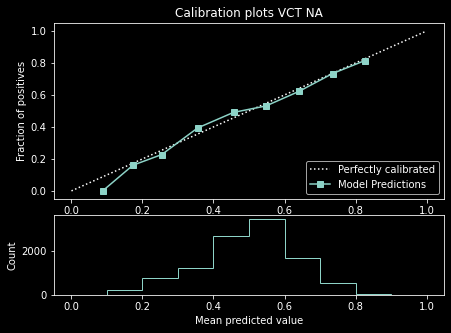

In [5]:
plt.style.use('dark_background')
fig = plotCalibrationCurve(
    y_true = y_true,
    y_pred = y_pred
)   
fig.show()

Get list of best players by wins_above_expected, defined in paper

In [6]:
dfplayers = getPlayersdf(dfexp)
dfplayers.sort_values(by = 'wins_above_expected', ascending = False).head(15)

Total Players: 39


,,team_name,tot_duels,tot_rounds,tot_games,exp_kills,tot_kills,wins_above_expected,med_diff,kills,KDA
playerId,Ign,,,,,,,,,,
1994,supamen,Rise,364,233,12,174.090378,196.0,0.060191,0.284692,196.0,1.166667
3074,aproto,Luminosity Gaming,147,88,5,69.608871,76.0,0.043477,0.326154,76.0,1.070423
1522,TiGG,Luminosity Gaming,151,94,5,76.088562,82.0,0.039149,0.264404,82.0,1.188406
1961,xeta,Cloud9 Blue,387,269,16,193.193802,208.0,0.038259,0.325060,208.0,1.162011
763,Asuna,100 Thieves,407,245,12,211.126404,223.0,0.029173,0.288804,223.0,1.211957
3346,BcJ,Scrounge and pros,269,180,10,127.713379,135.0,0.027088,0.224805,135.0,1.007463
10253,Ethan,100 Thieves,371,236,12,189.819290,198.0,0.022050,0.280782,198.0,1.144509
355,Hiko,100 Thieves,297,211,12,144.452682,151.0,0.022045,0.272740,151.0,1.034247
4639,vanity,Cloud9 Blue,421,281,16,209.322067,217.0,0.018237,0.245931,217.0,1.063725


Plot that list

In [7]:
fig = px.scatter(
    dfplayers.reset_index(), 
    x = 'KDA', y = 'wins_above_expected', color = 'team_name',text = "Ign",hover_data = ['Ign', 'team_name'],
    template = 'plotly_dark')

fig.update_traces(textposition = 'bottom right', textfont= {'size': 9})

fig.update_layout(
    font_family="Courier New",
)

Now look for players who are good getting kills with cheap guns, settled on Nitr0

In [8]:
dfecos = dfexp[(dfexp['pgun'] < 1600) & (dfexp['pgun'] > 0) & (dfexp['egun'] > 1600) & (dfexp['egun'] < 2902)]

dfplayers_ecos = getPlayersdf(dfecos)
dfplayers_ecos.sort_values(by = 'wins_above_expected', ascending = False).head(15)

Total Players: 27


,,team_name,tot_duels,tot_rounds,tot_games,exp_kills,tot_kills,wins_above_expected,med_diff,kills,KDA
playerId,Ign,,,,,,,,,,
1848,Oderus,Version1,13,10,5,3.669103,6,0.179300,-0.228671,6,0.857143
1994,supamen,Rise,26,19,10,7.740077,11,0.125382,-0.206023,11,0.733333
74,NaturE,Gen.G Esports,17,14,8,4.804776,6,0.070307,-0.206347,6,0.545455
3346,BcJ,Scrounge and pros,23,18,9,6.622449,8,0.059894,-0.229965,8,0.533333
1132,nitr0,100 Thieves,27,19,11,8.387783,10,0.059712,-0.219227,10,0.588235
2098,gMd,Gen.G Esports,15,11,7,4.420783,5,0.038614,-0.238013,5,0.500000
355,Hiko,100 Thieves,24,20,10,6.483992,7,0.021500,-0.218229,7,0.411765
494,dephh,XSET,29,23,9,8.538499,9,0.015914,-0.253882,9,0.450000
1990,poised,Rise,21,17,8,5.849186,6,0.007182,-0.214641,6,0.400000


Shap plot of that one prediction, used in paper

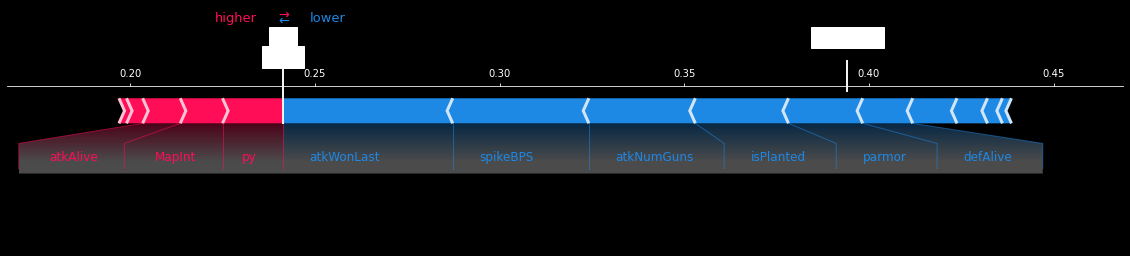

In [9]:
find_match = dfecos[dfecos['Ign'] == 'nitr0'].sort_values('DIFF')
df_shap = find_match[preds.features]
explainer = shap.TreeExplainer(preds.modelDEF, data= shap.sample(df_shap,100),model_output="probability");
shap_values = explainer.shap_values(df_shap)#[1]; # index 1 pulls the P(y=1) SHAP values for RandomForest.

id=24##Used in paper https://youtu.be/3QfaONI9gMo?t=8292
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[id],
               feature_names = preds.XDEF.columns, matplotlib=True)

Find players who struggled against Operator, decided on Hiko. 

Total Players: 15


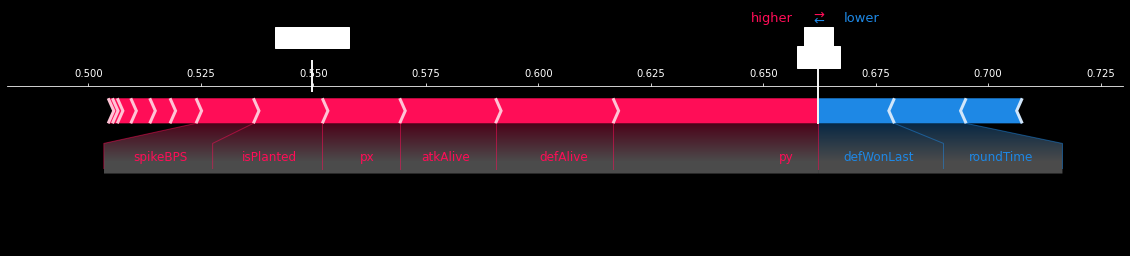

In [10]:
df_agOP = dfexp[(dfexp['egun'] > 4500)]
dfplayers_agOP = getPlayersdf(df_agOP)
dfplayers_agOP.sort_values(by = 'wins_above_expected', ascending = False).head(15)

find_match2 = df_agOP[df_agOP['Ign'] == 'Hiko'].sort_values('DIFF')
getribURL(find_match2)#%%
df_shap = find_match2[preds.features]
explainer = shap.TreeExplainer(preds.modelATK, data= shap.sample(df_shap,100),model_output="probability");
shap_values = explainer.shap_values(df_shap)

id=6 ##Used in paper
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[id],
               feature_names = preds.XATK.columns, matplotlib=True)

This time, test on the validation and test sets. To find correlation between tournaments

In [11]:
preds2 = PredATKDEF(
    NewData, 
    MD.train_matches, 
    MD.valid_test_matches, 
    features, 
    xgb.XGBClassifier(use_label_encoder = False, verbosity = 0, random_state=42,
             **optimal_params,),
    MD.df_ids 
    )
y_true, y_pred, dfexp = preds2.fitpred_ATKDEF()

In [12]:
dfexp_valid = dfexp[dfexp["matchId"].isin(MD.valid_matches)]
dfexp_test = dfexp[dfexp["matchId"].isin(MD.test_matches)]

common_players = set(dfexp_valid['playerId'].values).intersection(set(dfexp_test['playerId'].values))


dfpl_valid = getPlayersdf(dfexp_valid)
dfpl_test = getPlayersdf(dfexp_test)

Total Players: 37
Total Players: 39


Add the wins_above_expected metrics for the validation set (Challenger Playoffs) and test set (Last Chance Qualifiers)

In [13]:
all_scores = pd.read_csv('DATA_XY/VCT3_NA_Scores.csv')
valid_scores = all_scores[all_scores['MatchID'].isin(MD.valid_matches)]
test_scores = all_scores[all_scores['MatchID'].isin(MD.test_matches)]

score_cols = ['KDA', 'wins_above_expected']
dfcommon = dfpl_valid[score_cols].merge(dfpl_test[score_cols], how = 'inner', left_index = True, right_index = True)
dfcommon = dfcommon.droplevel('Ign')

dfcommon['validADR'] = valid_scores.groupby('playerId')['score'].mean()
dfcommon['testADR'] = test_scores.groupby('playerId')['score'].mean()  

Check pearson correlation

In [14]:
pearsonr(dfcommon['wins_above_expected_x'],dfcommon['wins_above_expected_y'])

(0.23349098217588113, 0.28360948954335846)

In [15]:
pearsonr(dfcommon['KDA_x'], dfcommon['KDA_y'])

(0.17223543597026497, 0.43195651244603356)

In [16]:
pearsonr(dfcommon['validADR'], dfcommon['testADR'])

(0.18535517408896293, 0.3971441787574859)